# <center> Traffic Volume Forecasting Project (Time Series)

### Introduction

### This project aims to analyze Time Series data of traffic volume for "Metro Interstate" and forecast future traffic hours.

### Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

c:\Users\lenovo\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Read CSV file
df = pd.read_csv('Metro_Interstate_Traffic_Volume.csv')
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


In [4]:
df.describe()

,temp,rain_1h,snow_1h,clouds_all,traffic_volume
count,48204.000000,48204.000000,48204.000000,48204.000000,48204.000000
mean,281.205870,0.334264,0.000222,49.362231,3259.818355
std,13.338232,44.789133,0.008168,39.015750,1986.860670
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,272.160000,0.000000,0.000000,1.000000,1193.000000
50%,282.450000,0.000000,0.000000,64.000000,3380.000000
75%,291.806000,0.000000,0.000000,90.000000,4933.000000
max,310.070000,9831.300000,0.510000,100.000000,7280.000000


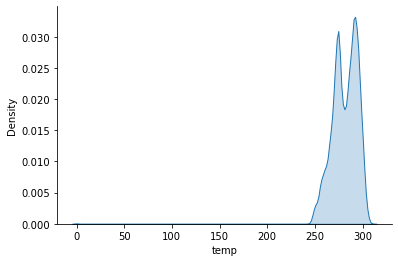

In [5]:
# Check Temperature distribution
sns.kdeplot(x= df.temp, shade= True)
sns.despine()

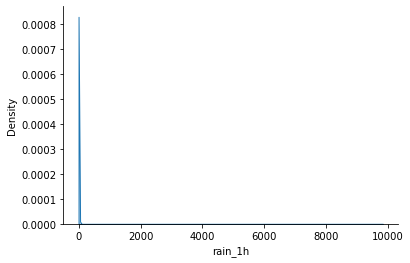

In [6]:
# Check Rain distribution
sns.kdeplot(x= df.rain_1h, shade= True)
sns.despine()

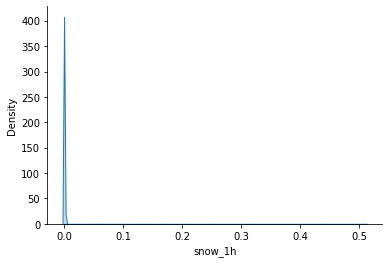

In [7]:
# Check Snow distribution
sns.kdeplot(x= df.snow_1h, shade= True)
sns.despine()

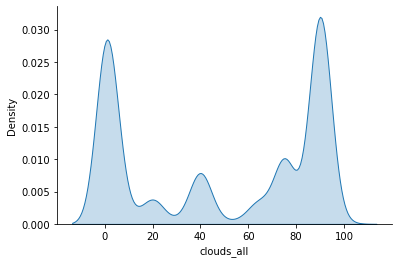

In [8]:
# Check Clouds distribution
sns.kdeplot(x= df.clouds_all, shade= True)
sns.despine()

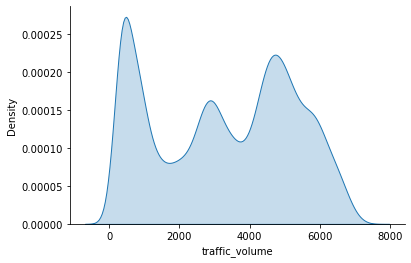

In [9]:
# Check Traffic volume distribution
sns.kdeplot(x= df.traffic_volume, shade= True)
sns.despine()

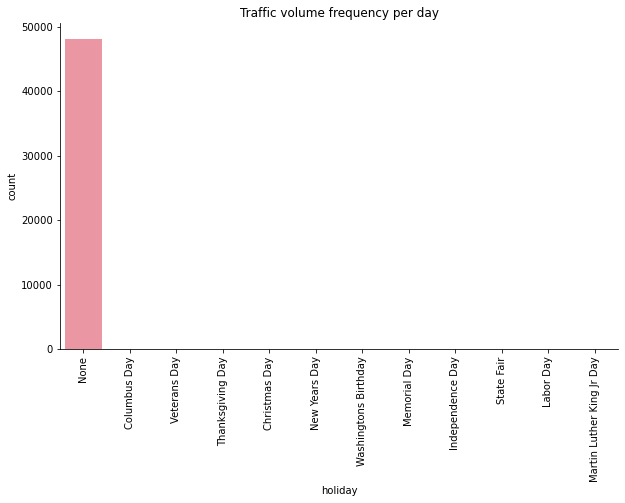

In [10]:
# Traffic volume frequency per day
plt.figure(figsize = [10,6])
sns.countplot(x= df['holiday'])
plt.title('Traffic volume frequency per day')
plt.xticks(rotation = 90)
sns.despine();

In [11]:
# convert the date time column to datetime format
df['date_time'] =  pd.to_datetime(df['date_time'], format='%Y-%m-%d %H:%M:%S')

In [12]:
# create new column for day name
df['weekday']= df['date_time'].dt.day_name()

In [13]:
# Show statistics of traffic volume for each day
df.groupby('weekday')['traffic_volume'].agg(['mean','count','min','max','sum']).sort_values(by= 'sum')

,mean,count,min,max,sum
weekday,,,,,
Sunday,2368.588329,6872,3,6645,16276939
Saturday,2773.638120,6831,0,6470,18946722
Monday,3309.387161,7072,123,7117,23403986
Tuesday,3488.555799,6846,125,7217,23882653
Thursday,3637.899663,6817,1,7280,24799562
Wednesday,3583.196681,6930,1,7192,24831553
Friday,3656.358836,6836,10,7241,24994869


#### As we noticed above, saturday and sunday has the lowest traffic as they are weekends

In [14]:
# Sort dataframe by date_time to begin time series processing
df= df.sort_values(by= 'date_time')

In [15]:
# Set date_time column as index of data frame
df.set_index('date_time', inplace= True)

In [16]:
df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,weekday
date_time,,,,,,,,,
2012-10-02 09:00:00,None,288.28,0.0,0.0,40,Clouds,scattered clouds,5545,Tuesday
2012-10-02 10:00:00,None,289.36,0.0,0.0,75,Clouds,broken clouds,4516,Tuesday
2012-10-02 11:00:00,None,289.58,0.0,0.0,90,Clouds,overcast clouds,4767,Tuesday
2012-10-02 12:00:00,None,290.13,0.0,0.0,90,Clouds,overcast clouds,5026,Tuesday
2012-10-02 13:00:00,None,291.14,0.0,0.0,75,Clouds,broken clouds,4918,Tuesday


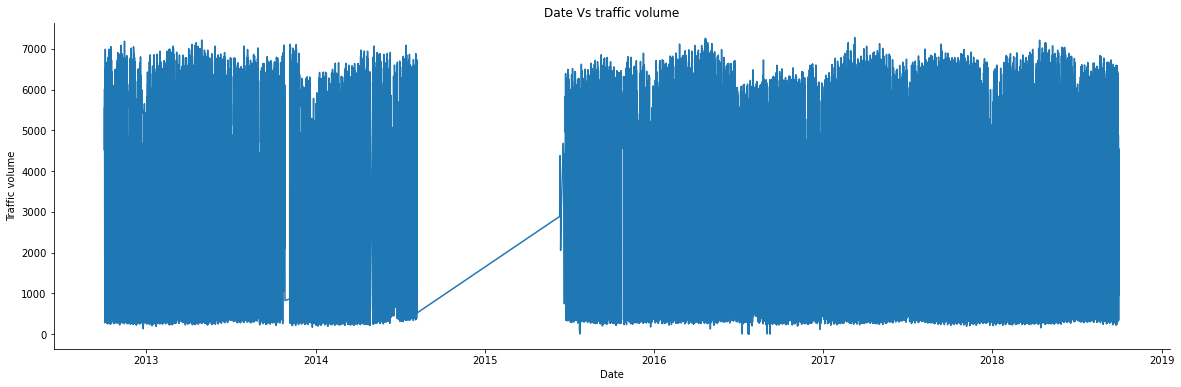

In [17]:
# Plot Date Vs Traffic volume
plt.figure(figsize=[20,6])
plt.plot(df.index, df['traffic_volume'])
plt.xlabel('Date')
plt.ylabel('Traffic volume')
plt.title('Date Vs traffic volume')
sns.despine()

#### Due to the gap in the data we will take sample only from "2017" to "2018"

In [18]:
portion_df = df.traffic_volume['2017-09-29':'2018-09-29']

In [19]:
portion_df

date_time
2017-09-29 00:00:00     751
2017-09-29 01:00:00     432
2017-09-29 02:00:00     310
2017-09-29 03:00:00     348
2017-09-29 04:00:00     860
                       ... 
2018-09-29 19:00:00    3818
2018-09-29 20:00:00    3338
2018-09-29 21:00:00    2950
2018-09-29 22:00:00    2607
2018-09-29 23:00:00    3856
Name: traffic_volume, Length: 10626, dtype: int64

In [20]:
# Split data into Train & Test in order matter
split_date = '2018-08-30'
ts_train = portion_df[portion_df.index <= split_date]
ts_test = portion_df[portion_df.index > split_date]

#### Check whether data is stationary or not

In [21]:
def test_stationarity(timeseries):
    
    # Determie rolling statistics
    rolmean = timeseries.rolling(168).mean()
    rolstd = timeseries.rolling(168).std()

    # Plot rolling statistics:
    plt.figure(figsize=[20,6])
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    print (dfoutput)

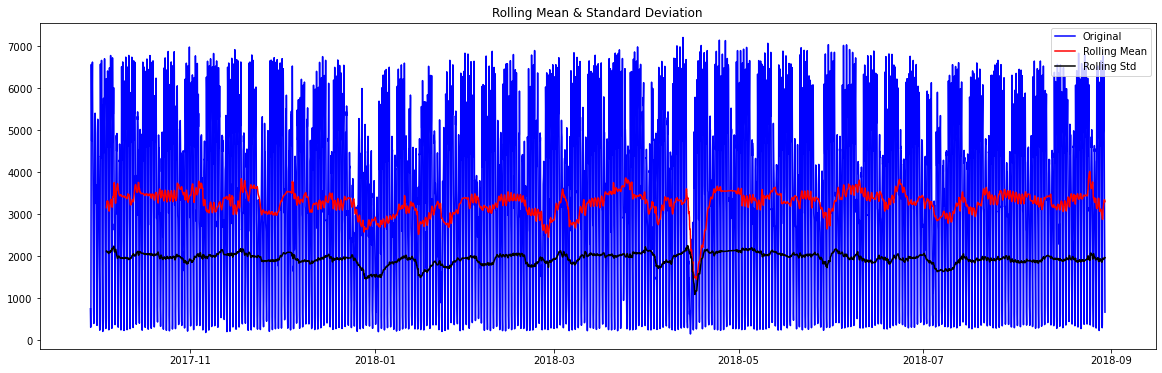

Results of Dickey-Fuller Test:
Test Statistic                -1.548486e+01
p-value                        2.528511e-28
#Lags Used                     3.300000e+01
Number of Observations Used    9.624000e+03
Critical Value (1%)           -3.431030e+00
Critical Value (5%)           -2.861840e+00
Critical Value (10%)          -2.566930e+00
dtype: float64


In [22]:
test_stationarity(ts_train)

#### We notice from the graph above that the mean of data is almost constnant with time meaning data is stationary

#### Building ARIMA Model

In [23]:
# ACF and PACF plots
lag = 168
lag_pacf = pacf(ts_train, nlags=lag, method='ols')
lag_acf = acf(ts_train, nlags=lag)

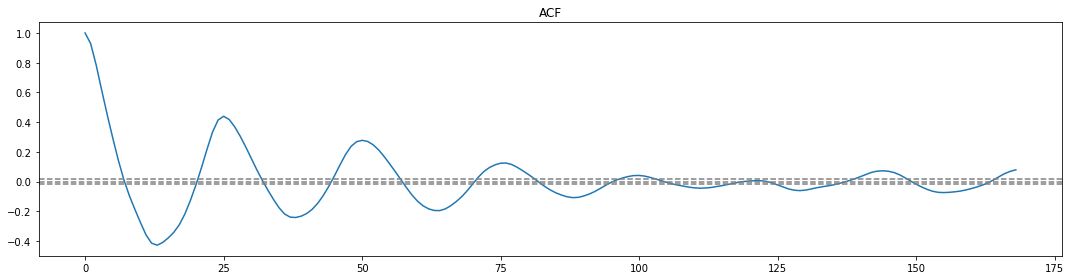

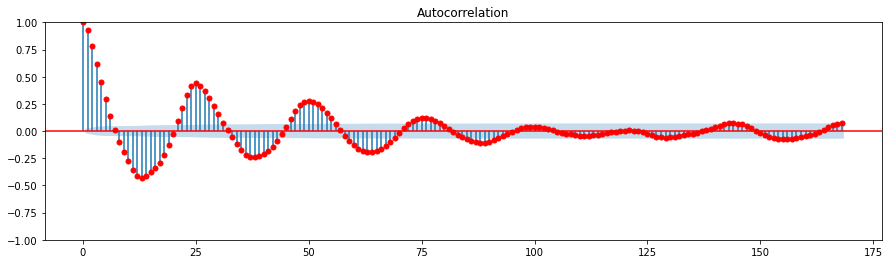

In [24]:
#Plot ACF auto corrletion function 
plt.figure(figsize=[15,4])
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(portion_df)), linestyle= '--', color= 'gray')
plt.axhline(y=1.96/np.sqrt(len(portion_df)), linestyle= '--', color= 'gray')
plt.title('ACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=[15,4])
plot_acf(ts_train, ax= plt.gca(), lags= lag, color= 'red')
plt.show()

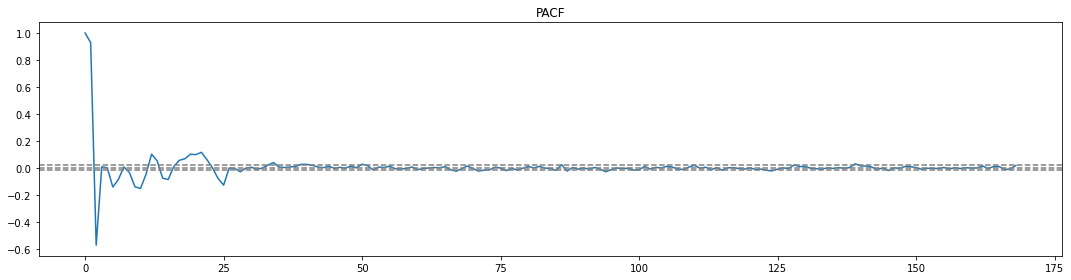

c:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


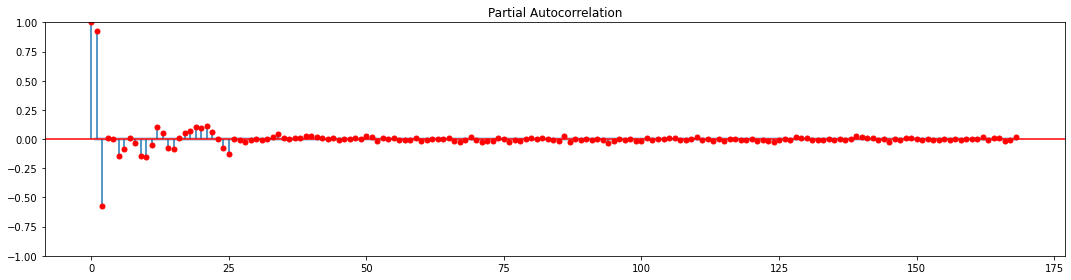

In [25]:
#Plot PACF partial auto corrletion function
plt.figure(figsize=(15,4))
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(portion_df)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(portion_df)),linestyle='--',color='gray')
plt.title('PACF')
plt.tight_layout()
plt.show()

plt.figure(figsize=(15,4))
plot_pacf(ts_train, ax=plt.gca(), lags=lag, color= 'red')
plt.tight_layout()
plt.show()

In [26]:
# Determine p, q and d values
p = 1                # from PACF Curve
q = 7                # from ACF Curve
d = 0                # From stationary test result

c:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


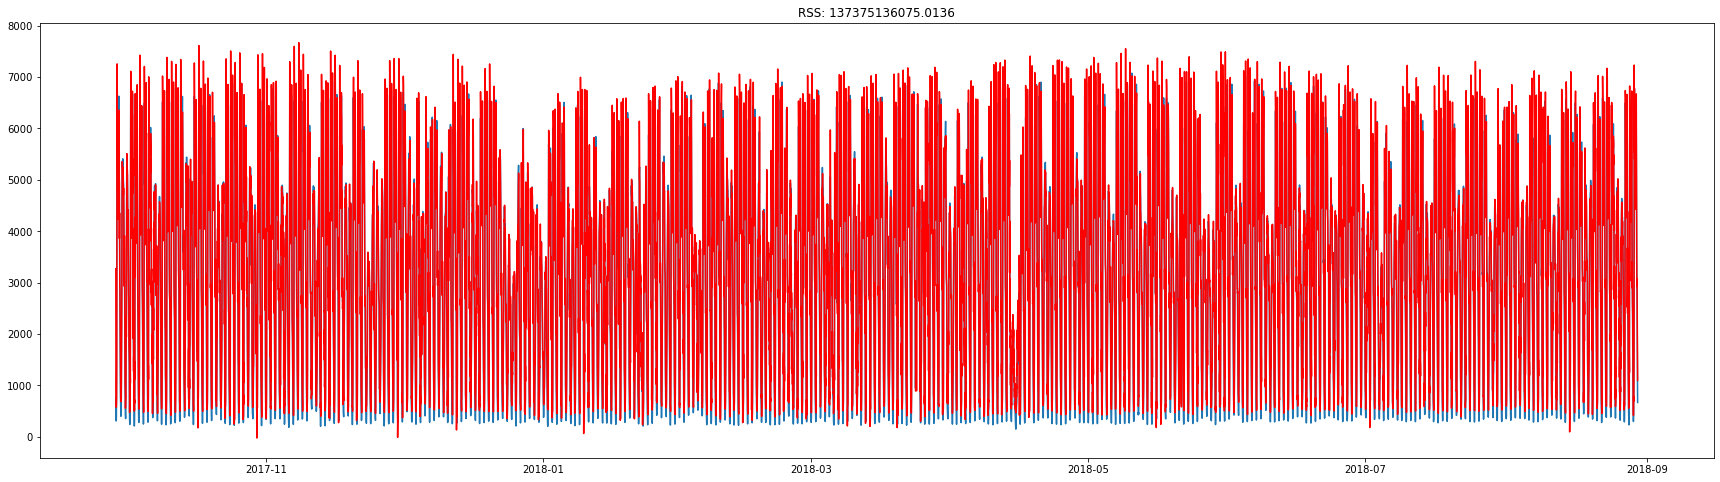

In [27]:
# ARIMA auto autoregressive integrated moving average
model = ARIMA(ts_train, order=(p, d, q))  
results_ARIMA = model.fit()
plt.figure(figsize= [30,8])
plt.plot(ts_train)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues).dropna()**2))
plt.show()

c:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


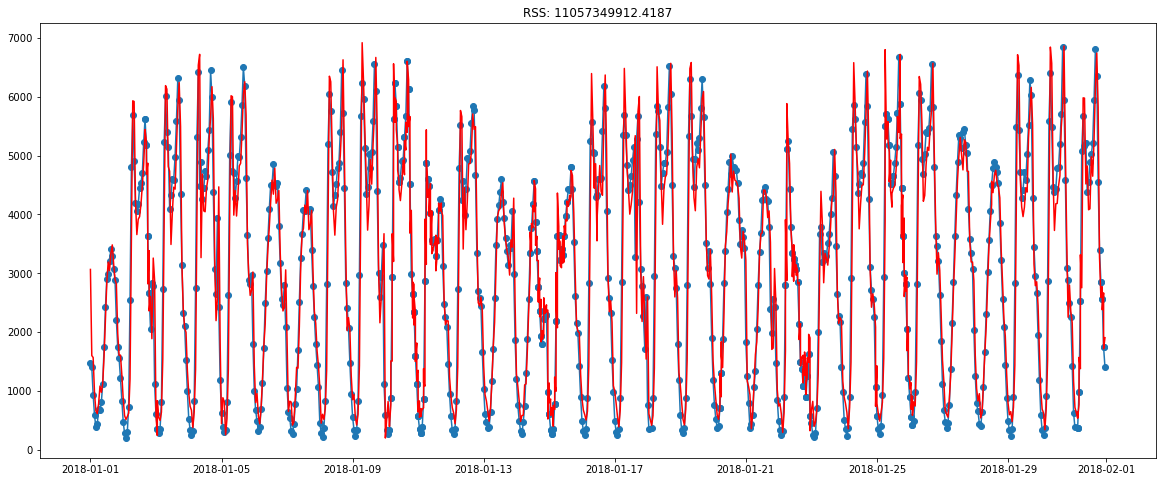

In [28]:
# Let's look closer on one month (2018-01)
model_month = ARIMA(ts_train['2018-01'], order=(p, d, q))  
results_ARIMA_month = model_month.fit()
plt.figure(figsize= [20,8])
plt.plot(ts_train['2018-01'], marker= 'o')
plt.plot(results_ARIMA_month.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA_month.fittedvalues).dropna()**2))
plt.show()

In [29]:
# summury of our model
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         traffic_volume   No. Observations:                 9658
Model:                 ARIMA(1, 0, 7)   Log Likelihood              -75380.274
Date:                Wed, 03 May 2023   AIC                         150780.548
Time:                        04:01:08   BIC                         150852.303
Sample:                             0   HQIC                        150804.878
                               - 9658                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3271.8723     62.809     52.092      0.000    3148.768    3394.976
ar.L1          0.3855      0.038     10.069      0.000       0.310       0.461
ma.L1          1.0796      0.036     29.653      0.000       1.008       1.151
ma.L2          1.0350      0.052     19.755      0.000       0.932       1.138
ma.L3          0.8265      0.056     14.754      0.000       0.717       0.936
ma.L4          0.6505      0.049     13.234      0.000       0.554       0.747
ma.L5          0.5077      0.040     12.731      0.000       0.430       0.586
ma.L6          0.3352      0.029     11.614      0.000       0.279       0.392
ma.L7          0.1408      0.016      8.717      0.000       0.109       0.172
sigma2      3.521e+05   3747.613     93.959      0.000    3.45e+05    3.59e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              2631.62
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               0.95   Skew:                             0.51
Prob(H) (two-sided):                  0.15   Kurtosis:                         5.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

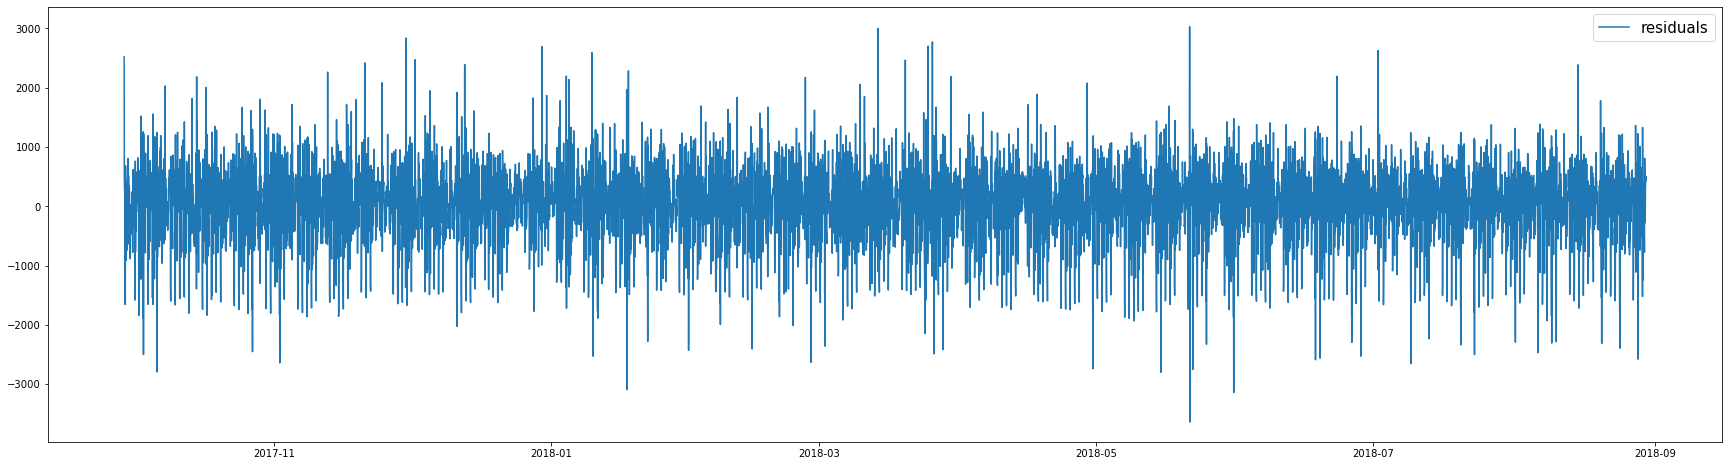

In [64]:
# Plot residual
x = pd.DataFrame(results_ARIMA.fittedvalues)
x.columns = ['traffic_volume']
x = x.traffic_volume - ts_train
plt.figure(figsize= [30,8])
plt.plot(x, label= 'residuals')
plt.legend(fontsize= 15, loc= 'best')
plt.show()

## Test the ARIMA model on test dataset

In [65]:
# Define function to get perdicted values
def StartARIMAForecasting(Actual, p, d, q):
	model = ARIMA(Actual, order=(p, d, q))
	model_fit = model.fit()
	prediction = model_fit.forecast()[0]
	return prediction

In [32]:
# new arrays to store actual and predictions
Actual = [x for x in ts_train]
Predictions = list()

# in a for loop, predict values using ARIMA model
for timepoint in range(len(ts_test)):
	ActualValue =  ts_test[timepoint]
	# forecast value
	Prediction = StartARIMAForecasting(Actual, 3,1,0)    
	print('Actual=%f, Predicted=%f' % (ActualValue, Prediction))
	# add it in the list
	Predictions.append(Prediction)
	Actual.append(ActualValue)  
 
predictions= pd.DataFrame(Predictions).set_index(ts_test.index)

Actual=456.000000, Predicted=451.471458
Actual=326.000000, Predicted=457.921056
Actual=388.000000, Predicted=327.401556
Actual=388.000000, Predicted=453.440948
Actual=1008.000000, Predicted=397.454896
Actual=1008.000000, Predicted=1354.240653
Actual=3070.000000, Predicted=968.993051
Actual=5886.000000, Predicted=4178.343727
Actual=6466.000000, Predicted=7359.270494
Actual=6466.000000, Predicted=6406.306649
Actual=5995.000000, Predicted=6140.861367
Actual=5467.000000, Predicted=5667.532099
Actual=4911.000000, Predicted=5196.369860
Actual=5095.000000, Predicted=4676.322031
Actual=5308.000000, Predicted=5289.070809
Actual=5213.000000, Predicted=5474.583191
Actual=5680.000000, Predicted=5126.580138
Actual=6238.000000, Predicted=5929.909844
Actual=6453.000000, Predicted=6535.679164
Actual=5775.000000, Predicted=6492.120973
Actual=4531.000000, Predicted=5318.329706
Actual=3884.000000, Predicted=3843.902688
Actual=3332.000000, Predicted=3664.289985
Actual=3049.000000, Predicted=3186.456793
Ac

In [69]:
# define function to calculate Mean Absolute Percentage Error
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [70]:
# Calculate Model error for: Mean Absolute Error, Root Mean Squared Error and Mean Absolute percentage Error
print('Test Mean Absolute Error:', mean_absolute_error(ts_test, predictions))
print('Test Root Mean Squared Error:',np.sqrt(mean_squared_error(ts_test, predictions)))
print('Test Mean Absolute Percentage Error:',mean_absolute_percentage_error(ts_test, predictions[0]))

Test Mean Absolute Error: 429.4805679629564
Test Root Mean Squared Error: 644.0588488489799
Test Mean Absolute Percentage Error: 19.07582392850202


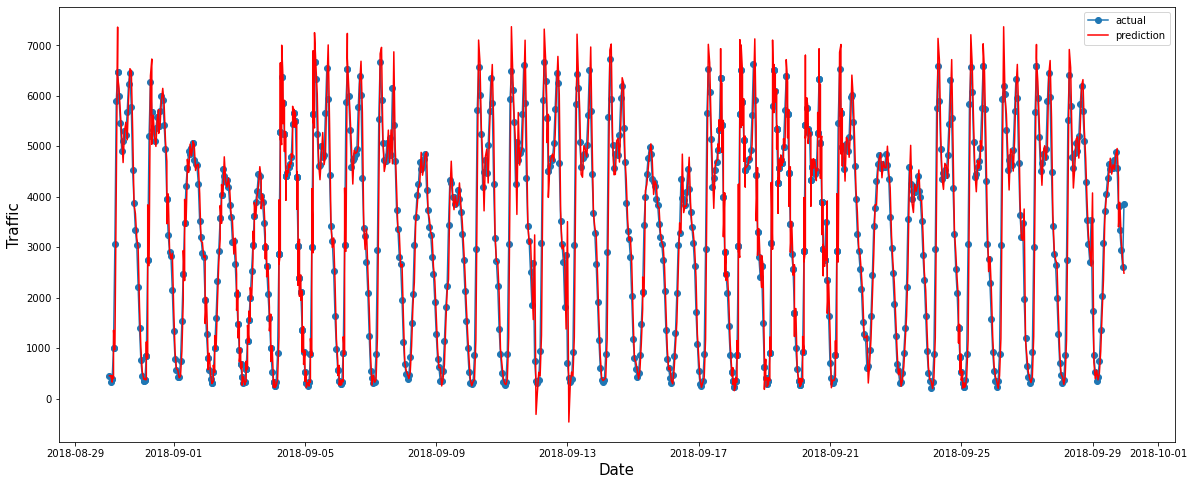

In [71]:
# plot actual value vs predicted
plt.figure(figsize=(20,8))
plt.plot(ts_test.index, ts_test, marker= 'o', label= "actual")
plt.plot(ts_test.index, Predictions, color= 'r', label= "prediction")
plt.ylabel('Traffic', size= 15)
plt.xlabel('Date', size= 15)
plt.legend(loc= 'upper right')

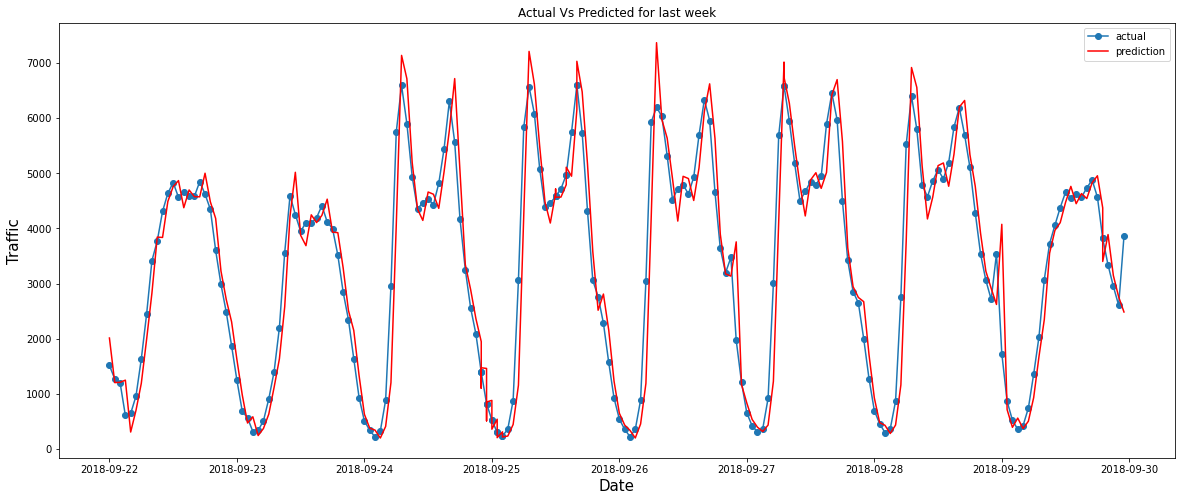

In [73]:
# plot actual value vs predicted
plt.figure(figsize=(20,8))

last_week_actual = ts_test.loc['2018-09-22' : '2018-09-29']
last_week_predicted = predictions[0]['2018-09-22' : '2018-09-29']

plt.plot(last_week_actual.index, last_week_actual, marker= 'o', label= "actual")
plt.plot(last_week_predicted.index, last_week_predicted, color= 'r', label= "prediction")
plt.ylabel('Traffic', size= 15)
plt.xlabel('Date', size= 15)
plt.title('Actual Vs Predicted for last week')
plt.legend(loc= 'upper right')

In [79]:
datetime.datetime.strptime("2018-09-29 23:00:00", "%Y-%m-%d %H:%M:%S")

datetime.datetime(2018, 9, 29, 23, 0)

In [122]:
# Get the next 8 hours of Traffic
from dateutil.relativedelta import relativedelta
start= datetime.datetime.strptime("2018-09-30 00:00:00", "%Y-%m-%d %H:%M:%S")
date_list= [start + relativedelta(hours= x) for x in range(0,8)]
future_predictions= pd.DataFrame(index= date_list, columns= df.columns)
future_predictions

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,weekday
2018-09-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-30 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-30 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-30 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-30 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-30 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-30 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-30 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
# concat the test data with the next 8 houre to predict the future data
data= pd.concat([ts_test, future_predictions], axis=0)

In [124]:
data= data.iloc[:,0]
data

2018-08-30 01:00:00     456.0
2018-08-30 02:00:00     326.0
2018-08-30 03:00:00     388.0
2018-08-30 03:00:00     388.0
2018-08-30 04:00:00    1008.0
                        ...  
2018-09-30 03:00:00       NaN
2018-09-30 04:00:00       NaN
2018-09-30 05:00:00       NaN
2018-09-30 06:00:00       NaN
2018-09-30 07:00:00       NaN
Name: 0, Length: 976, dtype: float64

c:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


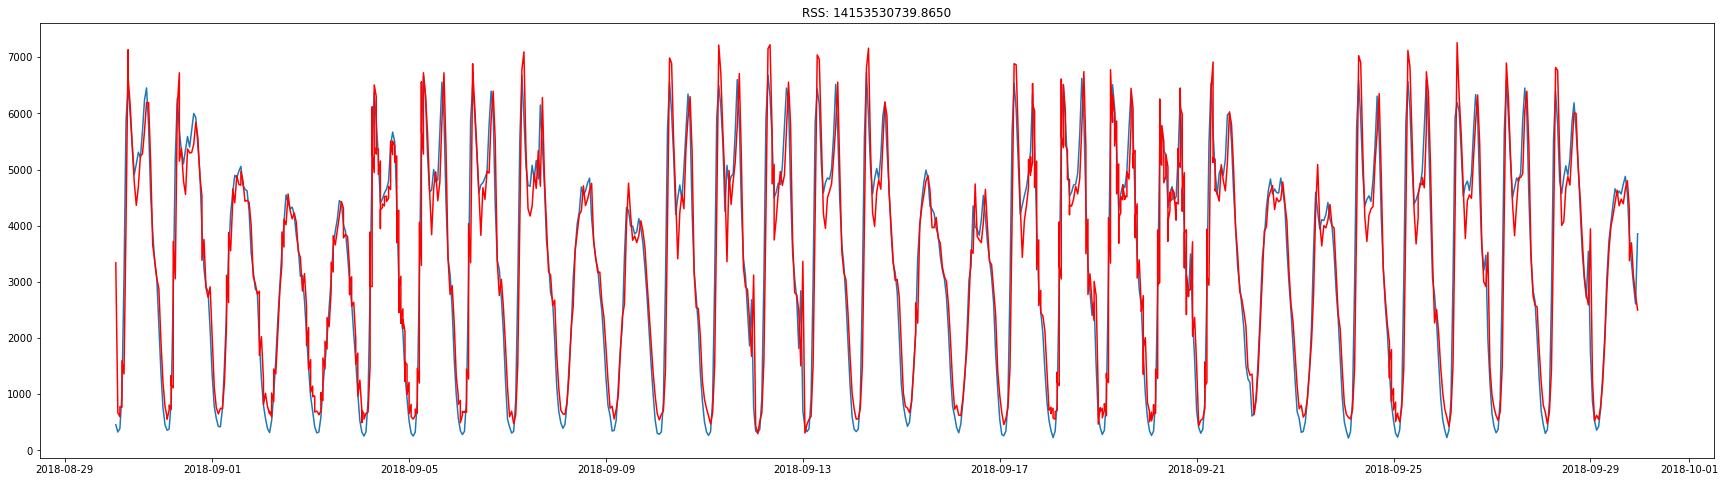

In [125]:
# ARIMA auto autoregressive integrated moving average
model = ARIMA(ts_test, order=(p, d, q))  
results_ARIMA = model.fit()
plt.figure(figsize=(30,8))
plt.plot(ts_test)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues).dropna()**2))
plt.show()

In [126]:
# Get prediction of the next 8 hours
pred= results_ARIMA.predict(start= len(ts_test), end= (len(data) - 1), dynamic= True)
pred

c:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


968    4372.690124
969    4723.265592
970    4803.024119
971    4657.067525
972    4453.862324
973    4179.879085
974    3861.014197
975    3496.184249
Name: predicted_mean, dtype: float64

In [127]:
data['2018-09-30 00:00:00' : '2018-09-30 07:00:00'].index

DatetimeIndex(['2018-09-30 00:00:00', '2018-09-30 01:00:00',
               '2018-09-30 02:00:00', '2018-09-30 03:00:00',
               '2018-09-30 04:00:00', '2018-09-30 05:00:00',
               '2018-09-30 06:00:00', '2018-09-30 07:00:00'],
              dtype='datetime64[ns]', freq=None)

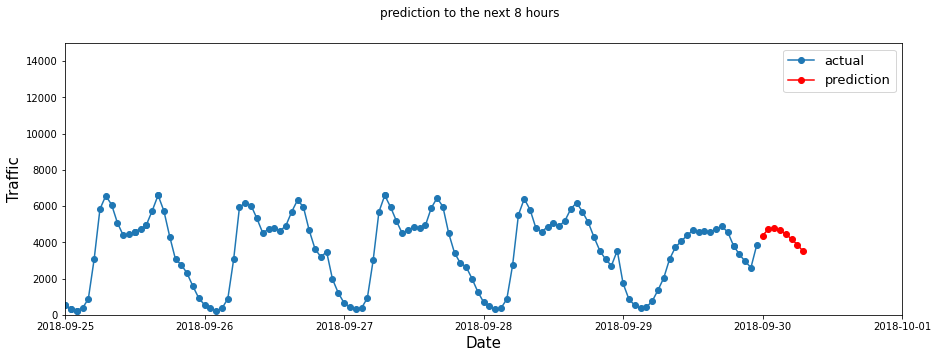

In [129]:
# plot prediction for next 8 hours
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(ts_test.index, ts_test, marker= 'o', label= "actual")
plt.plot(data['2018-09-30 00:00:00':'2018-09-30 07:00:00'].index, pred, color= 'r', label= "prediction", marker= 'o')
ax.set_xbound(lower= datetime.date(2018,9,25), upper=datetime.date(2018,10,1))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
plt.ylabel('Traffic',size = 15)
ax.set_ylim(0, 15000)
plot = plt.suptitle('prediction to the next 8 hours')

In [130]:
# Save future data 
Future ={'Datetime':date_list,'traffic':list(np.array(pred,dtype=int))}
Future

{'Datetime': [datetime.datetime(2018, 9, 30, 0, 0),
  datetime.datetime(2018, 9, 30, 1, 0),
  datetime.datetime(2018, 9, 30, 2, 0),
  datetime.datetime(2018, 9, 30, 3, 0),
  datetime.datetime(2018, 9, 30, 4, 0),
  datetime.datetime(2018, 9, 30, 5, 0),
  datetime.datetime(2018, 9, 30, 6, 0),
  datetime.datetime(2018, 9, 30, 7, 0)],
 'traffic': [4372, 4723, 4803, 4657, 4453, 4179, 3861, 3496]}

In [131]:
df_future_8hours=pd.DataFrame(Future)
df_future_8hours

,Datetime,traffic
0,2018-09-30 00:00:00,4372
1,2018-09-30 01:00:00,4723
2,2018-09-30 02:00:00,4803
3,2018-09-30 03:00:00,4657
4,2018-09-30 04:00:00,4453
5,2018-09-30 05:00:00,4179
6,2018-09-30 06:00:00,3861
7,2018-09-30 07:00:00,3496


In [132]:
# Get the next 12 hours of Traffic
from dateutil.relativedelta import relativedelta
start= datetime.datetime.strptime("2018-09-30 00:00:00","%Y-%m-%d %H:%M:%S")
date_list=[start + relativedelta(hours=x) for x in range(0,12)]
future_predictions= pd.DataFrame(index=date_list,columns=df.columns)
future_predictions

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,weekday
2018-09-30 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-30 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-30 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-30 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-30 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-30 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-30 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-30 07:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-30 08:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-30 09:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [133]:
# Concat the test data with the next 12 houre to predict the future data
data= pd.concat([ts_test,future_predictions], axis=0)

In [134]:
data= data.iloc[:,0]

In [135]:
pred= results_ARIMA.predict(start= len(ts_test), end= (len(data) - 1), dynamic=True)

c:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


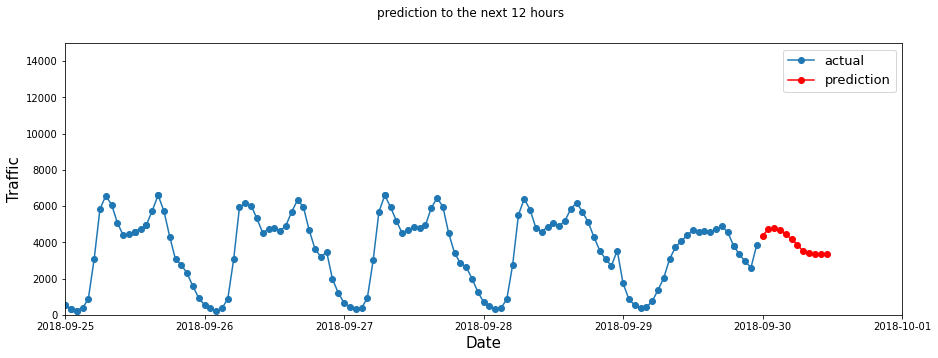

In [140]:
# Plot prediction for next 12 hours
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(ts_test.index, ts_test, marker= 'o', label= "actual")
plt.plot(data['2018-09-30 00:00:00':'2018-09-30 11:00:00'].index, pred, color= 'r', label= "prediction", marker= 'o')
ax.set_xbound(lower= datetime.date(2018,9,25), upper=datetime.date(2018,10,1))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
plt.ylabel('Traffic',size = 15)
ax.set_ylim(0, 15000)
plot = plt.suptitle('prediction to the next 12 hours')

In [141]:
# Save future data 
Future ={'Datetime':date_list,'traffic':list(np.array(pred,dtype=int))}
df_future_12hours= pd.DataFrame(Future)
df_future_12hours

,Datetime,traffic
0,2018-09-30 00:00:00,4372
1,2018-09-30 01:00:00,4723
2,2018-09-30 02:00:00,4803
3,2018-09-30 03:00:00,4657
4,2018-09-30 04:00:00,4453
5,2018-09-30 05:00:00,4179
6,2018-09-30 06:00:00,3861
7,2018-09-30 07:00:00,3496
8,2018-09-30 08:00:00,3386
9,2018-09-30 09:00:00,3353


In [393]:
actual_y = ts_test.iloc[-24:]
actual_y

date_time
2018-09-29 01:00:00     867
2018-09-29 02:00:00     524
2018-09-29 03:00:00     359
2018-09-29 04:00:00     425
2018-09-29 05:00:00     743
2018-09-29 06:00:00    1359
2018-09-29 07:00:00    2036
2018-09-29 08:00:00    3073
2018-09-29 09:00:00    3725
2018-09-29 10:00:00    4059
2018-09-29 11:00:00    4378
2018-09-29 12:00:00    4657
2018-09-29 13:00:00    4553
2018-09-29 14:00:00    4618
2018-09-29 15:00:00    4564
2018-09-29 16:00:00    4735
2018-09-29 17:00:00    4878
2018-09-29 18:00:00    4569
2018-09-29 19:00:00    3818
2018-09-29 19:00:00    3818
2018-09-29 20:00:00    3338
2018-09-29 21:00:00    2950
2018-09-29 22:00:00    2607
2018-09-29 23:00:00    3856
Name: traffic_volume, dtype: int64

In [394]:
ts_test_portion = ts_test.iloc[:-24]

In [395]:
ts_test_portion

date_time
2018-08-30 01:00:00     456
2018-08-30 02:00:00     326
2018-08-30 03:00:00     388
2018-08-30 03:00:00     388
2018-08-30 04:00:00    1008
                       ... 
2018-09-28 20:00:00    3538
2018-09-28 21:00:00    3058
2018-09-28 22:00:00    2713
2018-09-28 23:00:00    3544
2018-09-29 00:00:00    1733
Name: traffic_volume, Length: 944, dtype: int64

In [142]:
# Get the next 24 hours of Traffic
from dateutil.relativedelta import relativedelta
start= datetime.datetime.strptime("2018-09-30 00:00:00","%Y-%m-%d %H:%M:%S")
date_list=[start + relativedelta(hours=x) for x in range(0,24)]
future_predictions=pd.DataFrame(index=date_list, columns= df.columns)

In [143]:
# Concat the test data with the next 24 houre to predict the future data
data= pd.concat([ts_test, future_predictions], axis=0)

In [144]:
data=data.iloc[:,0]

In [150]:
pred= results_ARIMA.predict(start= len(ts_test), end= (len(data) - 1), dynamic= True)
pred

c:\Users\lenovo\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


968    4372.690124
969    4723.265592
970    4803.024119
971    4657.067525
972    4453.862324
973    4179.879085
974    3861.014197
975    3496.184249
976    3386.221572
977    3353.077937
978    3343.088179
979    3340.077186
980    3339.169648
981    3338.896109
982    3338.813662
983    3338.788812
984    3338.781322
985    3338.779064
986    3338.778384
987    3338.778179
988    3338.778117
989    3338.778098
990    3338.778093
991    3338.778091
Name: predicted_mean, dtype: float64

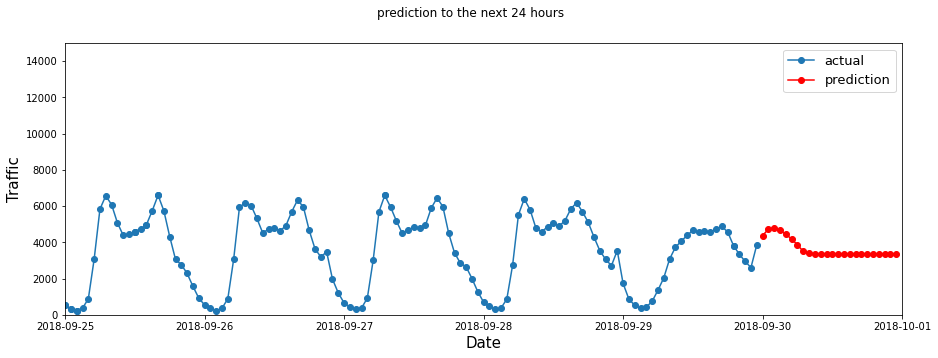

In [151]:
# plot prediction for next 24 hours
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
plt.plot(ts_test.index, ts_test, marker= 'o', label= "actual")
plt.plot(data['2018-09-30 00:00:00':'2018-09-30 23:00:00'].index, pred, color= 'r',label= "prediction", marker= 'o')
ax.set_xbound(lower= datetime.date(2018,9,25), upper=datetime.date(2018,10,1))
plt.legend(fontsize=13)
plt.xlabel('Date', size=15)
plt.ylabel('Traffic',size = 15)
ax.set_ylim(0, 15000)
plot = plt.suptitle('prediction to the next 24 hours')

In [155]:
# Save future data 
Future ={'Datetime':date_list,'traffic':list(np.array(pred,dtype=int))}
df_future_24hours= pd.DataFrame(Future)
df_future_24hours

,Datetime,traffic
0,2018-09-30 00:00:00,4372
1,2018-09-30 01:00:00,4723
2,2018-09-30 02:00:00,4803
3,2018-09-30 03:00:00,4657
4,2018-09-30 04:00:00,4453
5,2018-09-30 05:00:00,4179
6,2018-09-30 06:00:00,3861
7,2018-09-30 07:00:00,3496
8,2018-09-30 08:00:00,3386
9,2018-09-30 09:00:00,3353
